In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

from transformers import AutoTokenizer
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

## Data preparation
[Aspect-Level Sentiment Analysis in Czech](https://aclanthology.org/W14-2605/) (Steinberger et al., WASSA 2014)

In [4]:
#Dataset downloaded from https://corpora.kiv.zcu.cz/sentiment/
df = pd.read_csv("/content/drive/MyDrive/Newton/CzechRestaurants/data/CzechABSA-SemEval2014.csv")

In [5]:
df.rename(columns={"aspectTerms__aspectTerm__@polarity": "label", "aspectTerms__aspectTerm__@term": "aspect"}, inplace=True)
df = df[['text', 'aspect', 'label']]
df = df[df["label"] != "conflict"]
df['text'] = df['text'].fillna(method='ffill')
df = df.dropna()

<ipython-input-5-6f6f7b7cc095>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['text'] = df['text'].fillna(method='ffill')


## Basic information of the dataset
Such as text lengths, unique values, common aspects and value counts.

In [ ]:
df

,text,aspect,label
0,Jídlo taky nic moc,Jídlo,negative
1,Jídlo od Nás dostává 5 z 5 a pan Doksanský (sp...,spolumajitel,positive
2,Jídlo od Nás dostává 5 z 5 a pan Doksanský (sp...,personál,positive
3,Jídlo od Nás dostává 5 z 5 a pan Doksanský (sp...,pití,positive
4,Jídlo od Nás dostává 5 z 5 a pan Doksanský (sp...,jídlům,positive
...,...,...,...
3952,5.10.12 jsme si dávaly toto meníčko a můžu říc...,jídlo,negative
3953,5.10.12 jsme si dávaly toto meníčko a můžu říc...,jídlo,negative
3954,5.10.12 jsme si dávaly toto meníčko a můžu říc...,kuřecí roladá,negative
3955,5.10.12 jsme si dávaly toto meníčko a můžu říc...,povydla,negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3281 entries, 0 to 3956
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3281 non-null   object
 1   aspect  3281 non-null   object
 2   label   3281 non-null   object
dtypes: object(3)
memory usage: 102.5+ KB


In [ ]:
df.nunique()

,0
text,1658
aspect,1150
label,3


In [ ]:
df['label'].value_counts()

,count
label,
positive,1319
negative,1220
neutral,742


In [ ]:
print(f"Minimum length: {df['text'].apply(len).min()} char")
print(f"Average length: {df['text'].apply(len).mean():.1f} char")
print(f"Maximum length: {df['text'].apply(len).max()} char")
print(f"Minimum length: {df['text'].apply(lambda s: len(s.split())).min()} words")
print(f"Average length: {df['text'].apply(lambda s: len(s.split())).mean():.1f} words")
print(f"Maximum length: {df['text'].apply(lambda s: len(s.split())).max()} words")

Minimum length: 6 char
Average length: 124.0 char
Maximum length: 623 char
Minimum length: 2 words
Average length: 20.4 words
Maximum length: 111 words


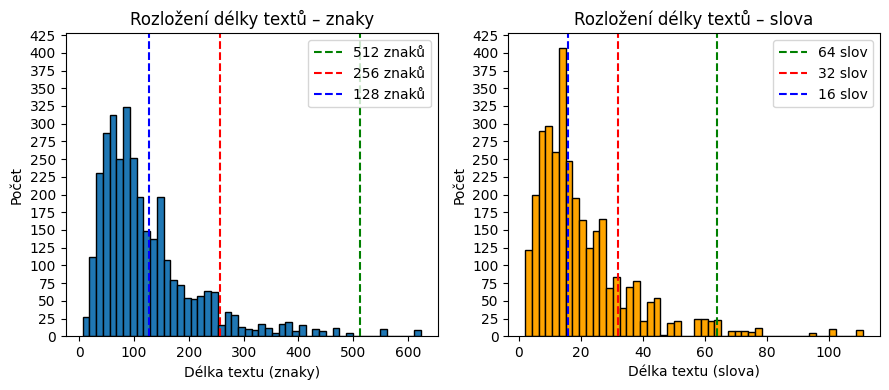

In [ ]:
# Graphs for lengths of text, in characters and in words
dff = df.copy()
dff["char_len"] = dff["text"].apply(len)
dff["word_len"] = dff["text"].apply(lambda s: len(s.split()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].hist(dff["char_len"], bins=50, edgecolor="black")
axes[0].axvline(512,  color="g", linestyle="--", label="512 znaků")
axes[0].axvline(256,  color="r", linestyle="--", label="256 znaků")
axes[0].axvline(128,  color="b", linestyle="--", label="128 znaků")
axes[0].set_xlabel("Délka textu (znaky)")
axes[0].set_ylabel("Počet")
axes[0].set_title("Rozložení délky textů – znaky")
axes[0].legend()

axes[1].hist(dff["word_len"], bins=50, edgecolor="black", color="orange")
axes[1].axvline(64,  color="g", linestyle="--", label="64 slov")
axes[1].axvline(32,  color="r", linestyle="--", label="32 slov")
axes[1].axvline(16,  color="b", linestyle="--", label="16 slov")
axes[1].set_xlabel("Délka textu (slova)")
axes[1].set_ylabel("Počet")
axes[1].set_title("Rozložení délky textů – slova")
axes[1].legend()

max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)

axes[0].set_yticks(range(0, int(max_y), 25))
axes[1].set_yticks(range(0, int(max_y), 25))

plt.tight_layout()
plt.show()

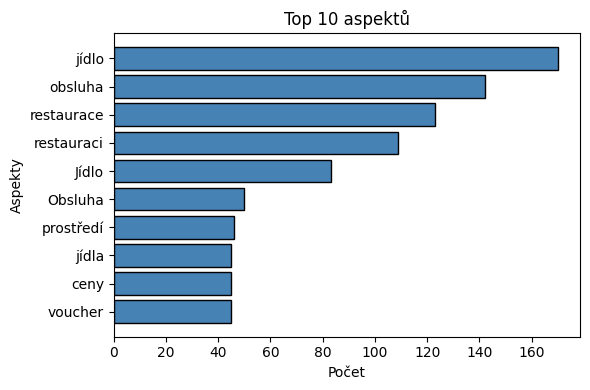

In [6]:
# Find the TOP 10 aspects
topN = 10
cat_counts = (df["aspect"].value_counts().head(topN).sort_values(ascending=True))

aspects = cat_counts.index.tolist()
frequencies = cat_counts.values.tolist()

plt.figure(figsize=(6, 4))

bar_color = "steelblue"
y_pos = range(len(aspects))

plt.barh(y_pos, frequencies, color=bar_color, edgecolor="black")
plt.yticks(y_pos, aspects)
plt.xlabel("Počet")
plt.ylabel("Aspekty")
plt.title(f"Top {topN} aspektů")
plt.tight_layout()
plt.show()

## Data seperation into train, val, test subsets

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)
train_df.to_csv("/content/drive/MyDrive/Newton/CzechRestaurants/data/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Newton/CzechRestaurants/data/val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Newton/CzechRestaurants/data/test.csv", index=False)
print(f"Train set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Train set size: 2296
Validation set size: 656
Test set size: 329


In [ ]:
print(f"Train set size: {train_df['label'].value_counts()}")
print(f"Validation set size: {val_df['label'].value_counts()}")
print(f"Test set size: {test_df['label'].value_counts()}")

Train set size: label
positive    942
negative    846
neutral     508
Name: count, dtype: int64
Validation set size: label
positive    269
negative    240
neutral     147
Name: count, dtype: int64
Test set size: label
negative    134
positive    108
neutral      87
Name: count, dtype: int64


## Difference of tokens needed for each sentence in the dataset usign differen tokenizers
For large version of models wont be shown any graphs, as they are usually usign the same tokenizer, just having more parameters

In [7]:
dataset = Dataset.from_pandas(df)

In [8]:
# Function for printing graphs for the length of tokenized sentences
def plot_tokenized_text(tokenizername, data):
    tokenizer = AutoTokenizer.from_pretrained(tokenizername)

    def tokenize_function(example):
        combined_input = f"aspekt: {example['aspect']} text: {example['text']}"

        encoding = tokenizer(
            combined_input,
            truncation=True,
            max_length=512
        )
        # Convert label from string to int
        encoding["label"] = label2id[example["label"]]
        return encoding

    def tokenize_functionQA(example):
        question_string = f"Jaký je sentiment tohoto aspektu: {example['aspect']}?"

        encoding = tokenizer(
            text=example["text"],
            text_pair=question_string,
            truncation=True,
            max_length=512
        )
        # Convert label from string to int
        encoding["label"] = label2id[example["label"]]
        return encoding

    def getLength(dataset):
        lengths = []
        for i in range(len(dataset)):
          lengths.append(len(dataset[i]))
        return lengths

    dataset = data.map(tokenize_function, batched=False, )
    datasetQA = data.map(tokenize_functionQA, batched=False)

    length = getLength(dataset['input_ids'])
    lengthQA = getLength(datasetQA['input_ids'])

    max_length_count = sum(seq >= 256 for seq in length)
    print(f"Number of tokenized texts with length over 256 tokens: {max_length_count} from total of {len(length)}")
    max_length_countQA = sum(seq >= 256 for seq in lengthQA)
    print(f"Number of tokenized texts using QA with length over 256 tokens: {max_length_countQA} from total of {len(lengthQA)}")

    print(f"The maximum length of tokenized text in dataset with {tokenizername}: " + str(max(length)))
    print(f"The maximum length of tokenized text in dataset with {tokenizername} using QA: " + str(max(lengthQA)))

    global_max = max(max(length), max(lengthQA))
    global_min = min(min(length), min(lengthQA))
    bin_edges  = np.linspace(global_min, global_max, 50 + 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    counts1, _, _ = axes[0].hist(length, bins=bin_edges, edgecolor="black", color="steelblue", label='_nolegend_')
    counts2, _, _ = axes[1].hist(lengthQA, bins=bin_edges, edgecolor="black", color="forestgreen", label='_nolegend_')

    axes[0].set_title(tokenizername)
    axes[0].set_xlabel("Délka textu (tokeny)")
    axes[0].set_ylabel("Počet")
    axes[0].axvline(x=256, color='r', linestyle='--', label='256 tokenů')
    axes[0].legend(loc='upper right')

    axes[1].set_title(tokenizername + "QA")
    axes[1].set_xlabel("Délka textu (tokeny)")
    axes[1].set_ylabel("Počet")
    axes[1].axvline(x=256, color='r', linestyle='--', label='256 tokenů')
    axes[1].legend(loc='upper right')

    ymax = max(counts1.max(), counts2.max()) + 20
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

Number of tokenized texts with length over 256 tokens: 9 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 9 from total of 3281
The maximum length of tokenized text in dataset with bert-base-uncased: 265
The maximum length of tokenized text in dataset with bert-base-uncased using QA: 273


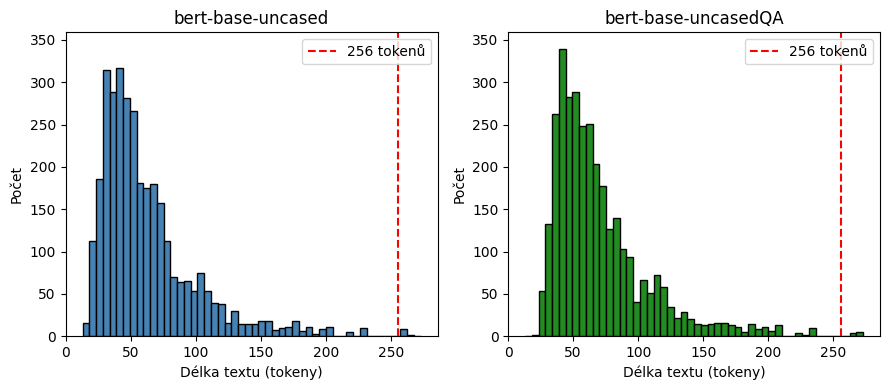

In [36]:
plot_tokenized_text("bert-base-uncased", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with bert-base-multilingual-cased: 237
The maximum length of tokenized text in dataset with bert-base-multilingual-cased using QA: 243


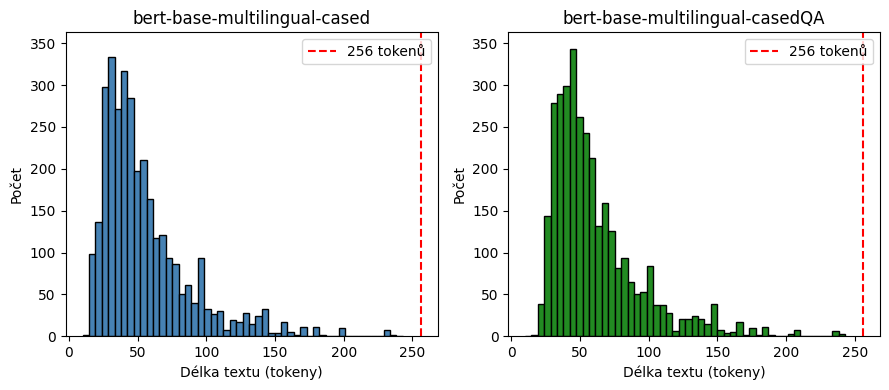

In [37]:
plot_tokenized_text("bert-base-multilingual-cased", dataset)

Number of tokenized texts with length over 256 tokens: 27 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 41 from total of 3281
The maximum length of tokenized text in dataset with roberta-base: 358
The maximum length of tokenized text in dataset with roberta-base using QA: 369


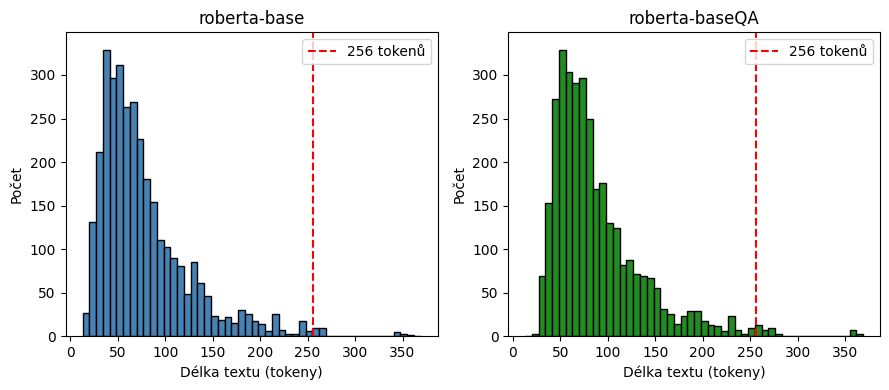

In [38]:
plot_tokenized_text("roberta-base", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with xlm-roberta-base: 207
The maximum length of tokenized text in dataset with xlm-roberta-base using QA: 214


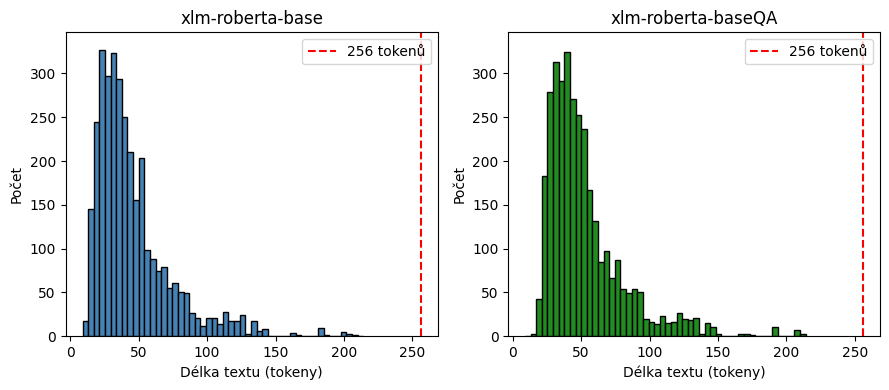

In [39]:
plot_tokenized_text("xlm-roberta-base", dataset)

Number of tokenized texts with length over 256 tokens: 9 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 9 from total of 3281
The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 281
The maximum length of tokenized text in dataset with microsoft/deberta-v3-base using QA: 289


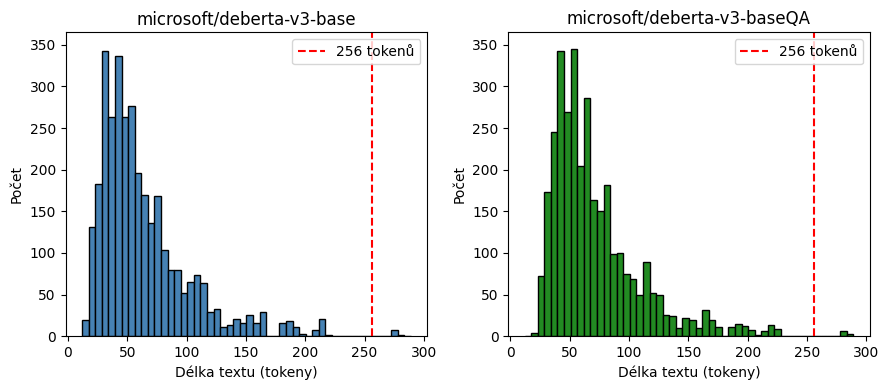

In [40]:
plot_tokenized_text("microsoft/deberta-v3-base", dataset)

Number of tokenized texts with length over 256 tokens: 9 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 9 from total of 3281
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base: 300
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base using QA: 309


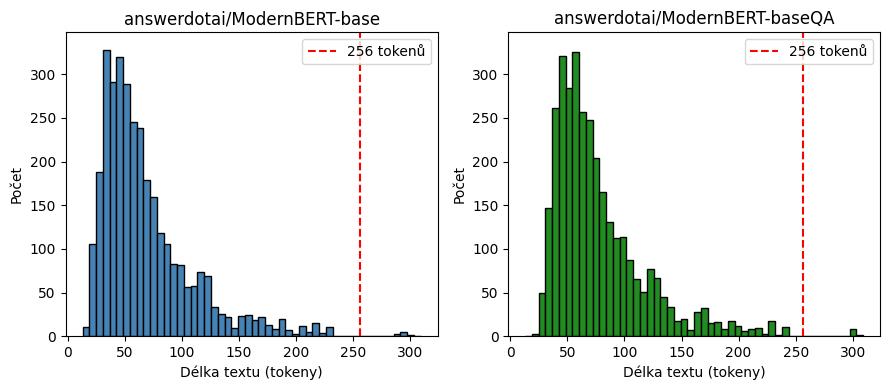

In [41]:
plot_tokenized_text("answerdotai/ModernBERT-base", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased: 195
The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased using QA: 201


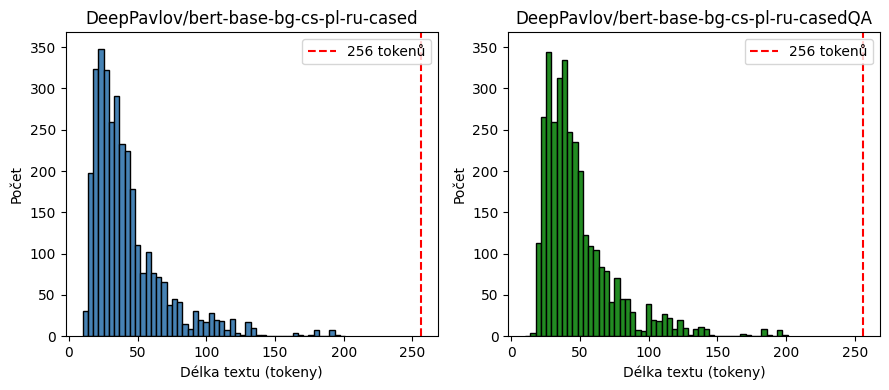

In [42]:
plot_tokenized_text("DeepPavlov/bert-base-bg-cs-pl-ru-cased", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 195
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased using QA: 201


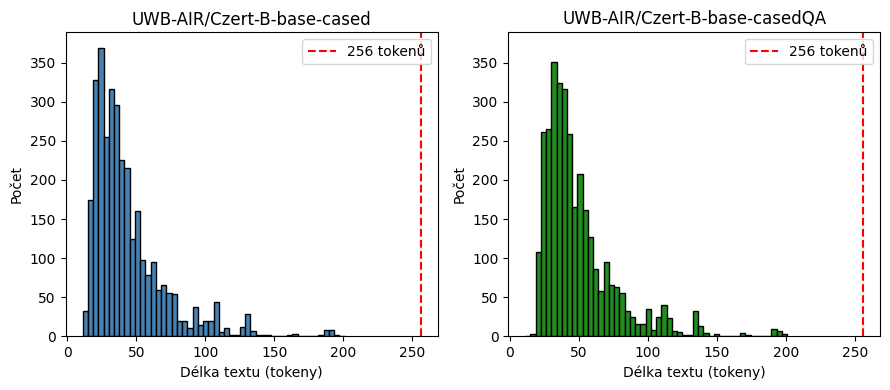

In [43]:
plot_tokenized_text("UWB-AIR/Czert-B-base-cased", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with ufal/robeczech-base: 183
The maximum length of tokenized text in dataset with ufal/robeczech-base using QA: 189


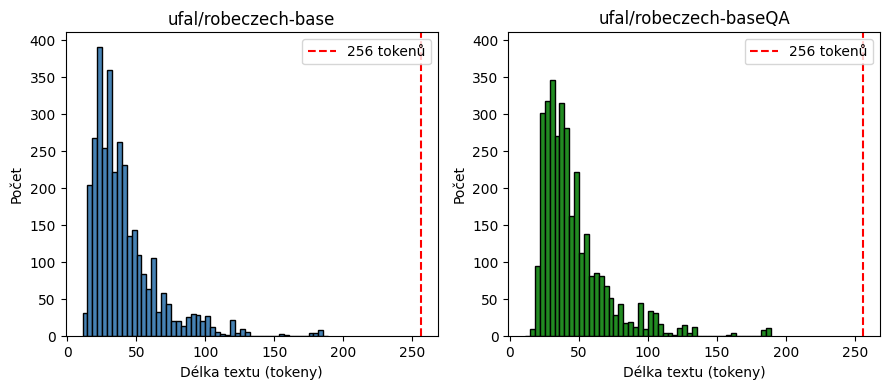

In [44]:
plot_tokenized_text("ufal/robeczech-base", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 176
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5 using QA: 181


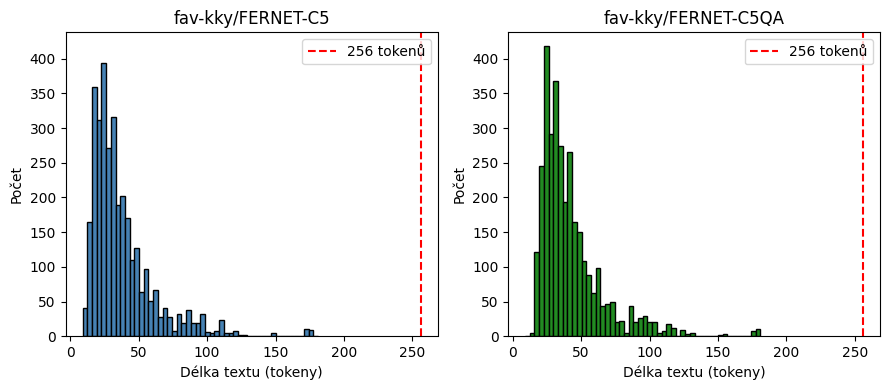

In [45]:
plot_tokenized_text("fav-kky/FERNET-C5", dataset)

Number of tokenized texts with length over 256 tokens: 0 from total of 3281
Number of tokenized texts using QA with length over 256 tokens: 0 from total of 3281
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 189
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa using QA: 194


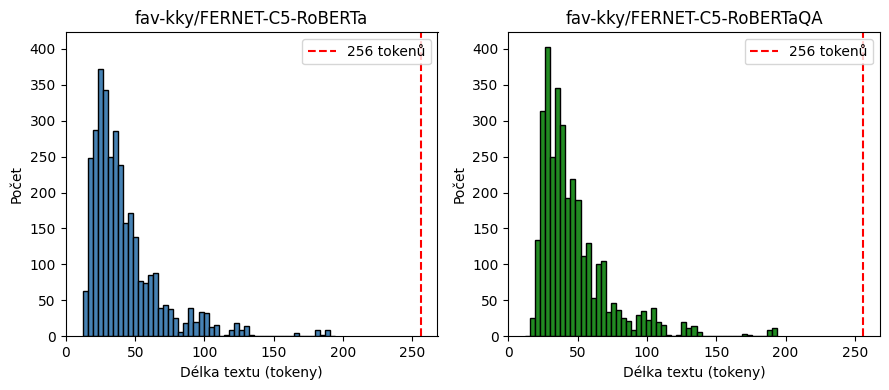

In [46]:
plot_tokenized_text("fav-kky/FERNET-C5-RoBERTa", dataset)

In [28]:
# Function for printing graphs for comparing the length of different tokenizors
def plot_tokenized_text_comparison(tokenizername1, tokenizername2, data):
    tokenizer1 = AutoTokenizer.from_pretrained(tokenizername1)
    tokenizer2 = AutoTokenizer.from_pretrained(tokenizername2)

    def encode(tokenizer):
        def tokenize(example):
            combined = f"aspekt: {example['aspect']} text: {example['text']}"
            out = tokenizer(combined, truncation=True, max_length=512)
            out["label"] = label2id[example["label"]]
            return out
        return tokenize

    def getLength(dataset):
        lengths = []
        for i in range(len(dataset)):
          lengths.append(len(dataset[i]))
        return lengths

    dataset1 = data.map(encode(tokenizer1), batched=False, )
    dataset2 = data.map(encode(tokenizer2), batched=False)

    length1 = getLength(dataset1['input_ids'])
    length2 = getLength(dataset2['input_ids'])

    print(f"The maximum length of tokenized text in dataset with {tokenizername1}: " + str(max(length1)))
    print(f"The maximum length of tokenized text in dataset with {tokenizername2}: " + str(max(length2)))

    global_max = max(max(length1), max(length2))
    global_min = min(min(length1), min(length2))
    bin_edges  = np.linspace(global_min, global_max, 50 + 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    counts1, _, _ = axes[0].hist(length1, bins=bin_edges, edgecolor="black", color="steelblue", label='_nolegend_')
    counts2, _, _ = axes[1].hist(length2, bins=bin_edges, edgecolor="black", color="forestgreen", label='_nolegend_')

    axes[0].set_title(tokenizername1)
    axes[0].set_xlabel("Délka textu (tokeny)")
    axes[0].set_ylabel("Počet")
    axes[0].axvline(x=256, color='r', linestyle='--', label='256 tokenů')
    axes[0].legend(loc='upper right')

    axes[1].set_title(tokenizername2)
    axes[1].set_xlabel("Délka textu (tokeny)")
    axes[1].set_ylabel("Počet")
    axes[1].axvline(x=256, color='r', linestyle='--', label='256 tokenů')
    axes[1].legend(loc='upper right')

    ymax = max(counts1.max(), counts2.max()) + 20
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

Comparison between the most effective tokenizer vs the least effective tokenizer

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 176
The maximum length of tokenized text in dataset with roberta-base: 358


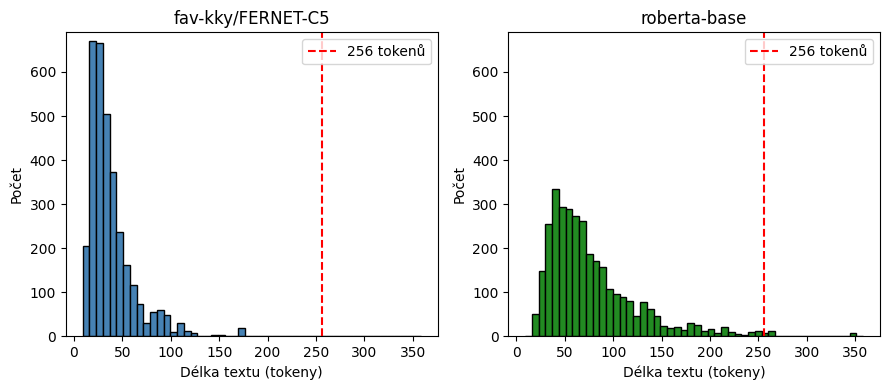

In [29]:
plot_tokenized_text_comparison("fav-kky/FERNET-C5", "roberta-base", dataset)

### Comparison between tokenizors of different languages
Comparing same models architectures, but with regard to their differnet trainig datasets

#### BERT models

The maximum length of tokenized text in dataset with bert-base-uncased: 265
The maximum length of tokenized text in dataset with bert-base-multilingual-cased: 237


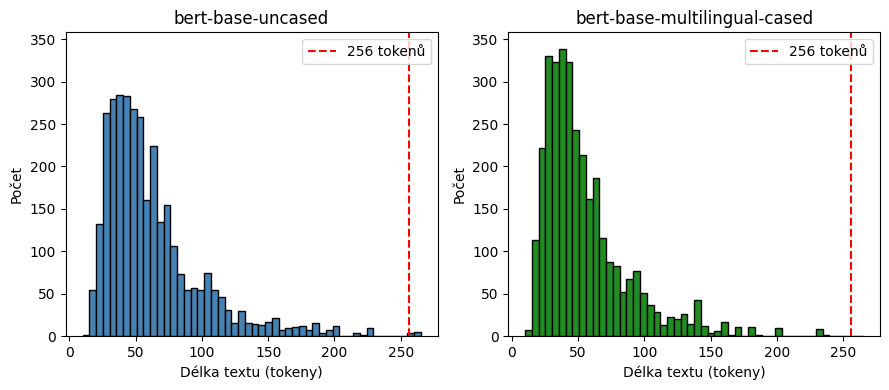

In [30]:
plot_tokenized_text_comparison("bert-base-uncased", "bert-base-multilingual-cased", dataset)

The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased: 195
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 195


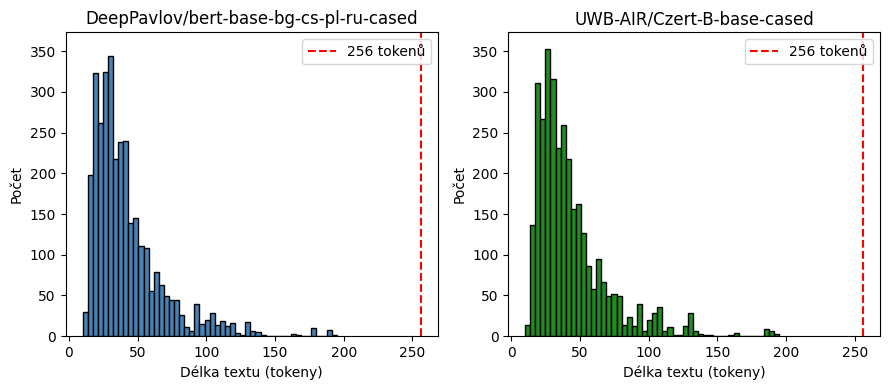

In [31]:
plot_tokenized_text_comparison("DeepPavlov/bert-base-bg-cs-pl-ru-cased", "UWB-AIR/Czert-B-base-cased", dataset)

The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 195
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 176


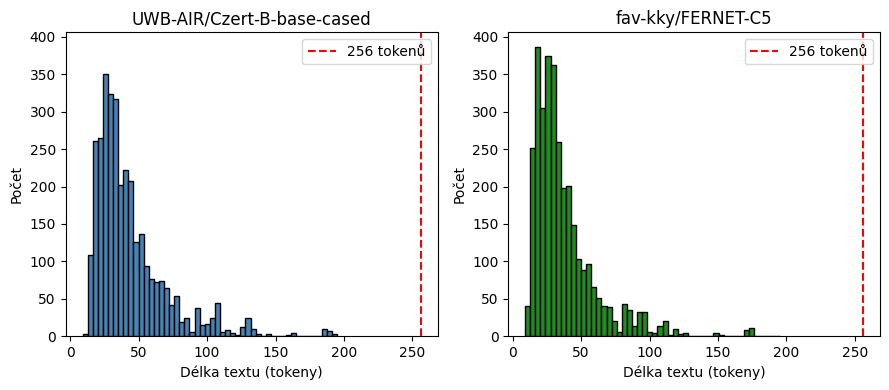

In [32]:
plot_tokenized_text_comparison("UWB-AIR/Czert-B-base-cased", "fav-kky/FERNET-C5", dataset)

#### RoBERTa models

The maximum length of tokenized text in dataset with roberta-base: 358
The maximum length of tokenized text in dataset with xlm-roberta-base: 207


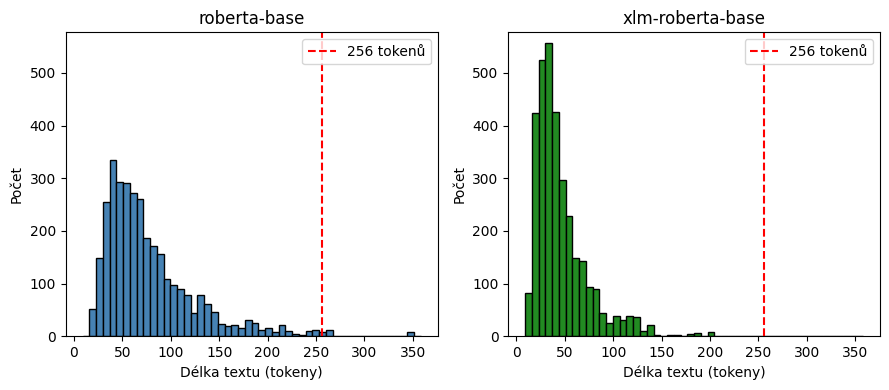

In [33]:
plot_tokenized_text_comparison("roberta-base", "xlm-roberta-base", dataset)

The maximum length of tokenized text in dataset with ufal/robeczech-base: 183
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 189


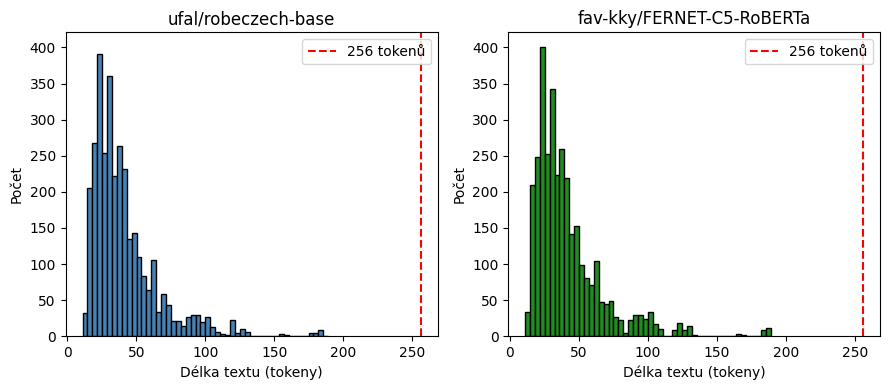

In [34]:
plot_tokenized_text_comparison("ufal/robeczech-base", "fav-kky/FERNET-C5-RoBERTa", dataset)

#### DeBERTaV3 vs ModernBERT - newest English models

The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 281
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base: 300


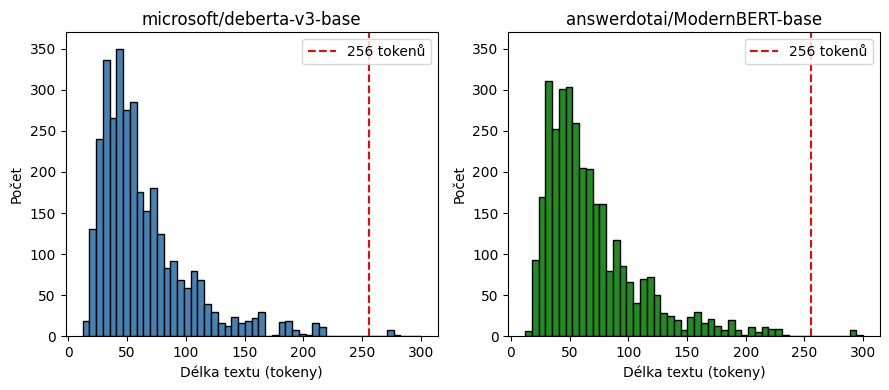

In [35]:
plot_tokenized_text_comparison("microsoft/deberta-v3-base", "answerdotai/ModernBERT-base", dataset)